<a href="https://www.kaggle.com/nurbekserzhanov/dota-2-organized-data-for-prediction-of-winner?scriptVersionId=86560758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dota-2-matches/players.csv
/kaggle/input/dota-2-matches/ability_upgrades.csv
/kaggle/input/dota-2-matches/test_player.csv
/kaggle/input/dota-2-matches/match_outcomes.csv
/kaggle/input/dota-2-matches/teamfights_players.csv
/kaggle/input/dota-2-matches/chat.csv
/kaggle/input/dota-2-matches/purchase_log.csv
/kaggle/input/dota-2-matches/test_labels.csv
/kaggle/input/dota-2-matches/ability_ids.csv
/kaggle/input/dota-2-matches/item_ids.csv
/kaggle/input/dota-2-matches/player_time.csv
/kaggle/input/dota-2-matches/patch_dates.csv
/kaggle/input/dota-2-matches/yasp_sample.json
/kaggle/input/dota-2-matches/match.csv
/kaggle/input/dota-2-matches/player_ratings.csv
/kaggle/input/dota-2-matches/hero_names.csv
/kaggle/input/dota-2-matches/cluster_regions.csv
/kaggle/input/dota-2-matches/teamfights.csv
/kaggle/input/dota-2-matches/objectives.csv


In [2]:
data_players=pd.read_csv('/kaggle/input/dota-2-matches/players.csv')
data_players.head()
data_matches=pd.read_csv('/kaggle/input/dota-2-matches/match.csv')
data_matches.head()
data_teamfights=pd.read_csv('/kaggle/input/dota-2-matches/teamfights.csv')
data_teamfights.head()



,match_id,start,end,last_death,deaths
0,0,220,252,237,3
1,0,429,475,460,3
2,0,900,936,921,3
3,0,1284,1328,1313,3
4,0,1614,1666,1651,5


In [15]:
#Grouping new data frame by match_id and collection all heroes together than split them by team
import time
start_time = time.time()


dire_data=data_players.groupby('match_id')['hero_id'].apply(list)
def divide_by_team(df,new_df):
    for j in range(df.shape[0]):
        new_r=list()
        for i in range(5):
            new_r.append(df[j].pop(df[j].index(df[j][0])))
        dictionnar={"Radiant_team":new_r}
        new_df=new_df.append(dictionnar,ignore_index=True) 
    return new_df


radiant_data = pd.DataFrame()
radiant_data=divide_by_team(dire_data,radiant_data)#--- 86.03843569755554 seconds ---

print("--- %s seconds ---" % (time.time() - start_time))#136.3190200328827 sec for split method

--- 84.54780888557434 seconds ---


In [ ]:
#Adding the data into data_matches and dropping the useless columns
data_matches['Radiant_team']=radiant_data
data_matches['Dire_team']=dire_data
data_matches=data_matches.drop(columns=['start_time','duration','game_mode','positive_votes','negative_votes','cluster'])
data_matches.columns


In [16]:
#Adding the mean_values of features which would be grouped by match_id
def adding_mean_values_of_diff_features_by_team(df,groupby,features,new_df):
    for i in range(len(features)):
        dire_data=df.groupby(groupby)[features[i]].apply(list)
        radiant_data=pd.DataFrame()
        radiant_data=divide_by_team(dire_data,radiant_data)
        radiant_data=radiant_data['Radiant_team'].apply(lambda x : sum(x)/len(x))
        dire_data=dire_data.apply(lambda x :sum(x)/len(x))
        new_df[features[i]+'_radiant']=radiant_data
        new_df[features[i]+'_dire']=dire_data
    return new_df

In [17]:
features=['gold_spent','gold_per_min','xp_per_min','kills','deaths','tower_damage','hero_damage']
data_matches=adding_mean_values_of_diff_features_by_team(data_players,'match_id',features,data_matches)
print(data_matches.head())

   match_id  start_time  duration  tower_status_radiant  tower_status_dire  \
0         0  1446750112      2375                  1982                  4   
1         1  1446753078      2582                     0               1846   
2         2  1446764586      2716                   256               1972   
3         3  1446765723      3085                     4               1924   
4         4  1446796385      1887                  2047                  0   

   barracks_status_dire  barracks_status_radiant  first_blood_time  game_mode  \
0                     3                       63                 1         22   
1                    63                        0               221         22   
2                    63                       48               190         22   
3                    51                        3                40         22   
4                     0                       63                58         22   

   radiant_win  ...  xp_per_min_radiant  xp_

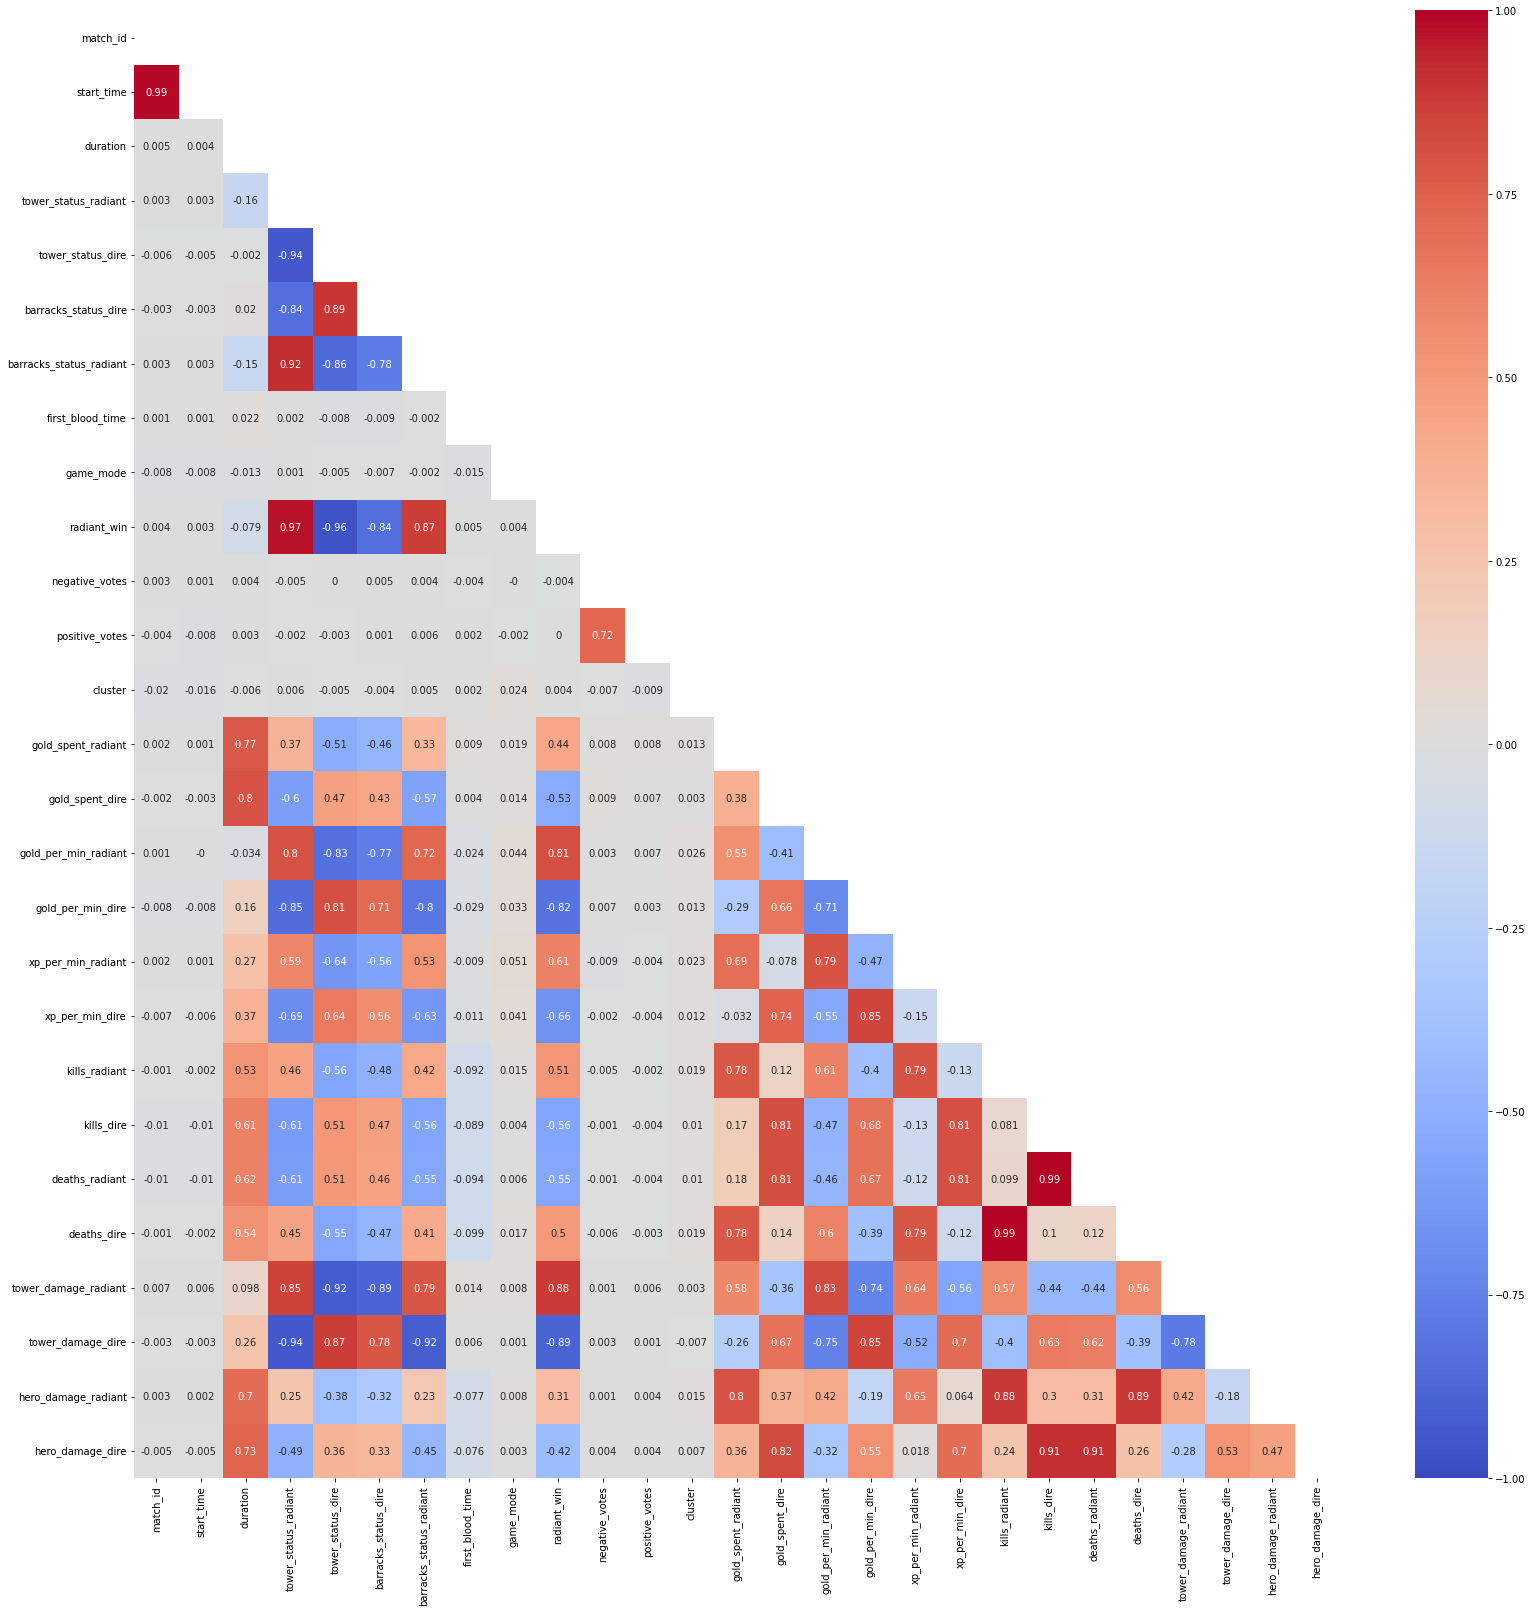

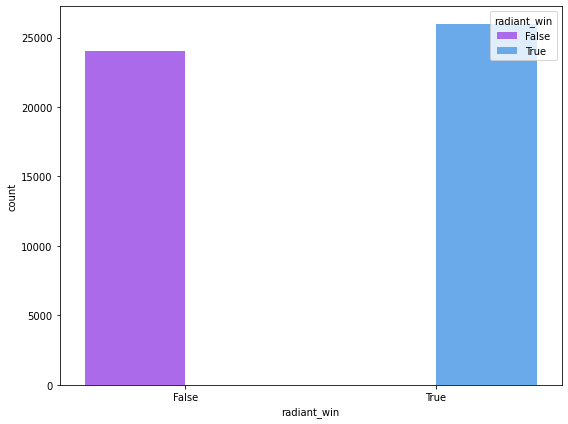

In [18]:
#Lets see the correlation between values and hist of wins
import matplotlib.pyplot as plt
import seaborn as sns
def corr_heatmap(df, digits=3, cmap='coolwarm'):
    """
    Creates a correlation heatmap to easily visualize multicollinearity
    that might be present in the dataframe.

    Args:
        df (DataFrame) : DataFrame with features to check multicollinearity on.
        digits (int) : Number of decimal places to display
        cmap (str) : Colormap to display correlation range.

    Returns:
        fig : Matplotlib Figure
        ax : Matplotlib Axis
    """
    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    
    
    mask[np.triu_indices_from(mask)] = True
    

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax
corr_heatmap(data_matches)
fig, ax = plt.subplots(figsize=(8,6))
# sns.histplot(x='blueWins', data=diff_df, hue='blueWins', palette='Set1',bins=(2), kde=False)
sns.countplot(x='radiant_win', data=data_matches, hue='radiant_win', palette='cool_r')

# Save as image
plt.tight_layout()


In [19]:
from matplotlib.gridspec import GridSpec
def visual_eda(df, target, col):
    """
    Plots a histogram + KDE, boxplot, and scatter plot with linear regression 
    line of the specified column. Use to visualize shape of data, outliers, 
    and check column's correlation with target variable.

    Args:
        df (DataFrame) : DataFrame containing column to plot
        target (str) : Name of target variable.
        col (str) : Name of the column to plot.

    Returns:
        fig : Matplotlib Figure
        gs : Matplotlib GridSpec
    """
    # Create copy variables of df and col
    data = df[col].copy()
    name = col

    # Calc mean and mean
    median = data.median()
    mean = data.mean()
    
    
    # Create gridspec for plots
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])

    # Plot distribution 
    sns.histplot(data,alpha=0.5,stat='density',ax=ax0)
    sns.kdeplot(data,color='green',label='KDE',ax=ax0)
    ax0.set(ylabel='Density',title=name)
    ax0.set_title(F"Distribution of {name}")
    ax0.axvline(median,label=f'median={median:,}',color='black')
    ax0.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    ax0.legend()

    # Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(F"Box Plot of {name}")

    # Plot Scatterplot to illustrate linearity
    sns.regplot(data=df, x=col, y=target, line_kws={"color": "red"}, ax=ax2)
    ax2.set_title(F"Scatter Plot of {name}")

    # Tweak Layout & Display
    fig.tight_layout()
   
    return fig, gs

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


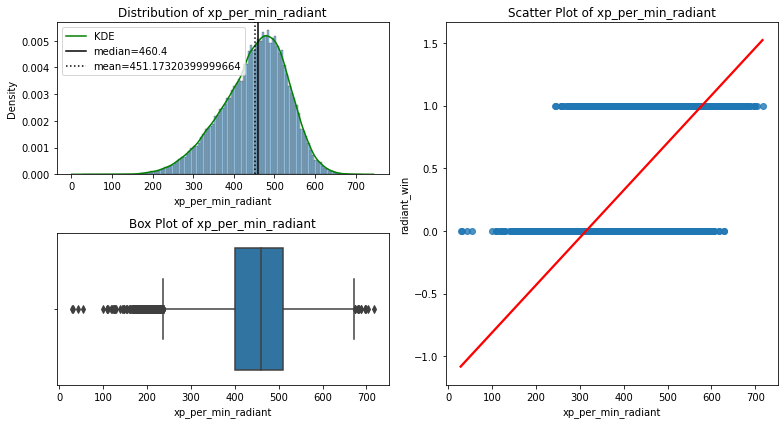

In [20]:
visual_eda(data_matches, 'radiant_win', 'xp_per_min_radiant');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


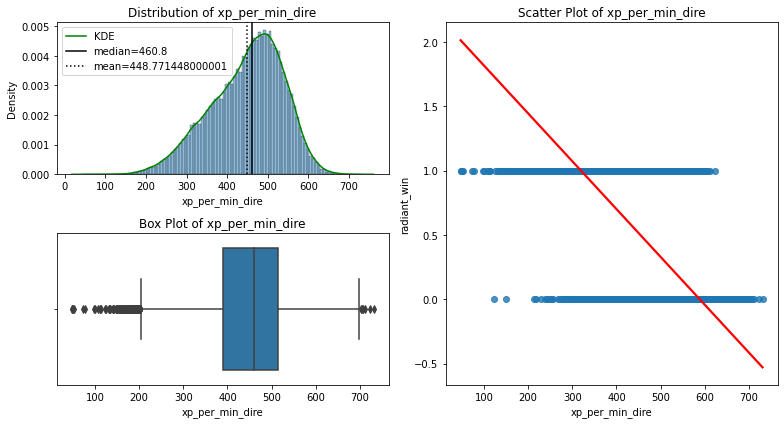

In [21]:
visual_eda(data_matches, 'radiant_win', 'xp_per_min_dire');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


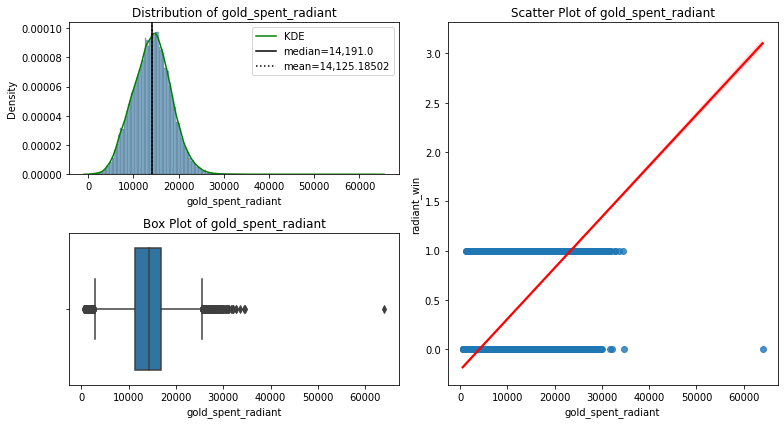

In [22]:
visual_eda(data_matches, 'radiant_win', 'gold_spent_radiant');

In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4, 
                   figsize=(10,5), params=False): 
    """
    Displays evaluation metrics including classification report, confusion
    matrix, ROC-AUC curve.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    Args:
        df (DataFrame) : DataFrame with features to check multicollinearity on.
        model (classifier object) : Type of classificatier model to use.
        X_train (DataFrame) : Training data with feature variables.
        y_train (Series) : Training data with target variable.
        X_test (DataFrame) : Testing data with feature variables.
        y_test (Series) : Testing data with target variable.
        digits (int) : Colormap to display correlation range. Default is 4.
        figsize (int, int) : Figure dimensions. Default is (10,5)
        params (bool) : Prints table of hyperparameters used in model.
        
    Returns:
    """
        
    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)
    
    # Classification Report / Scores 

    print("****CLASSIFICATION REPORT - TRAINING DATA****")
    
    print(metrics.classification_report(y_train,y_hat_train, digits=digits))
    

    print("****CLASSIFICATION REPORT - TEST DATA****")
    
    print(metrics.classification_report(y_test,y_hat_test, digits=digits))

    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")

    
    fig, axes = plt.subplots(ncols=2, 
                             figsize=figsize)
    
    # Confusion Matrix
    metrics.plot_confusion_matrix(model, X_test,
                                  y_test,normalize='true',
                                 cmap='Purples',ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    
    # Plot ROC Curve
    metrics.plot_roc_curve(model,X_test,y_test,ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0,1],[0,1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')
    
    plt.tight_layout()
    plt.show()
    
    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns=['parameters']
        display(params)
    return y_hat_test

In [43]:
from sklearn.preprocessing import StandardScaler
def split_scale(df, target, scaler=StandardScaler()):
    """
    Creates train-test splits and scales training data.

    Args:
        df (DataFrame): DataFrame with features and target variable.
        target (str): Name of target variable.
        scaler (scaler object): Scaler to use on features DataFrame. Default
                                is StandardScaler.
        
    Returns:
        X_train (DataFrame) : Training data with scaled feature variables.
        y_train (Series) : Training data with target variable.
        X_test (DataFrame) : Testing data with scaled feature variables.
        y_test (Series) : Testing data with target variable.
    """
    
    
    # Separate X and y
    target = target
    y = df[target]
    X = df.drop(target, axis=1)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Get list of column names
    cols = X_train.columns
    
    # Scale columns
    scaler = scaler
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)
    
    return X_train, X_test, y_train, y_test

In [44]:
def fit_eval(model, X_train, y_train, X_test, y_test, digits=4, 
             figsize=(10,5), params=False):
    """
    Fits model on training data and displays classification evaluation metrics.

    Args:
        model (classifier object) : Type of classificatier model to use.
        X_train (DataFrame) : Training data with feature variables.
        y_train (Series) : Training data with target variable.
        X_test (DataFrame) : Testing data with feature variables.
        y_test (Series) : Testing data with target variable.
        digits (int) : Colormap to display correlation range. Default is 4.
        figsize (int, int) : Figure dimensions. Default is (10,5)
        params (bool) : Prints table of hyperparameters used in model.
        
    Returns:
        model (classifier object) : Model after fitting on training data.
    """
    model.fit(X_train, y_train)

    pred=evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits, 
                   figsize=figsize, params=params)
    
    return model,pred

In [45]:
# Create training and test data splits.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = split_scale(data_matches, 'radiant_win')


****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

       False     0.9961    0.9965    0.9963     18038
        True     0.9967    0.9964    0.9965     19462

    accuracy                         0.9964     37500
   macro avg     0.9964    0.9964    0.9964     37500
weighted avg     0.9964    0.9964    0.9964     37500

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

       False     0.9958    0.9937    0.9948      6019
        True     0.9941    0.9961    0.9951      6481

    accuracy                         0.9950     12500
   macro avg     0.9950    0.9949    0.9950     12500
weighted avg     0.9950    0.9950    0.9950     12500

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


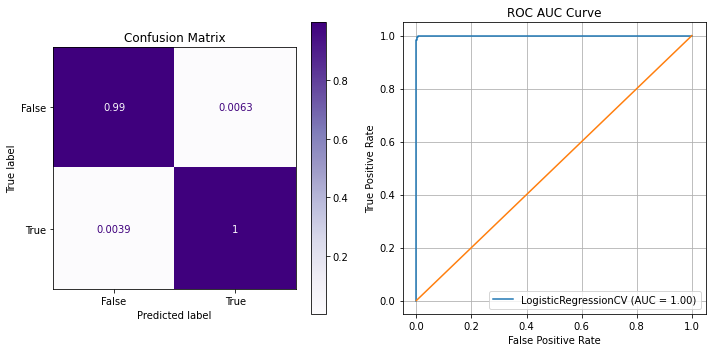

In [46]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
log,pred = fit_eval(LogisticRegressionCV(random_state=42), x_train, y_train, x_test, y_test)

In [53]:
print(pred)
true_test_data=pd.read_csv('/kaggle/input/dota-2-matches/test_labels.csv')
true_test_data.sort_values(by=['match_id'])
print(true_test_data.head())
data_matches.shape

[ True False  True ... False False  True]
   match_id  radiant_win
0     50000            0
1     50001            1
2     50002            0
3     50003            1
4     50004            0


(50000, 27)